<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Decide which algorithm and version of the data we are going to use for model training
(it'll be neural network in this file)

Additionally, choose:
* if we'll skip scaling the data
* if we'll use full categories instead of dummies
* what fraction of the data we'll use for testing (0.1)
* if the data split will be randomised (it won't!)

In [2]:
#ALGORITHM = 'Neural Network'
ALGORITHM = 'Neural Network [TYPE]'
ALGORITHM_DETAIL = ''
ALGORITHM_DETAIL_ORIG = ALGORITHM_DETAIL
#ALGORITHM_DETAIL += ' tbc'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '09'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

price_divisor = 1


#selected_neural_network='simplest'
#selected_neural_network='quite simple'
#selected_neural_network='recommended simple v2'
#selected_neural_network='adapted v3'


# ---- FIRST NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = 'recommended simple v1'
#selected_nn_code = 'm01 simple'

# ---- 2nd NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m02 two layers"


# ---- 3rd NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m03 2 layers+wider"


# ---- 4th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m04 3 layers+wider"

# ---- 5th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m05 rec deep"

# ---- 6th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m05 my deep"

#selected_neural_network = selected_nn_code = ""

# ---- 7th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m11 mega"

# ---- 8th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m12 mega"

# ---- 9th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m13 mega"

# ---- 10th NEURAL NETWORK STRUCTURE DEFINITION ---- #
#selected_neural_network = selected_nn_code = "m14 mega"

# ---- 10th NEURAL NETWORK STRUCTURE DEFINITION ---- #
selected_neural_network = selected_nn_code = "m15 mega + dropout"



ALGORITHM = ALGORITHM.replace("[TYPE]", selected_nn_code)

create_python_script = True

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: loading all dependencies



In [3]:
import os

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False


if is_jupyter:
    #! pip install scikeras
    !pip install tabulate

In [4]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
import sklearn
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle
from datetime import datetime

import json
import matplotlib.pyplot as plt
import sys
import os

start_timestamp = datetime.now()

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

if "JPY_PARENT_PID" in os.environ:
    is_jupyter = True
else:
    is_jupyter = False

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
OVERRIDE_VERBOSE = 1
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

already_timed = False
no_dummies = 'no dummies' in DATA_DETAIL
no_scaling = 'no scaling' in DATA_DETAIL
#not_catboost = 'catboost' not in ALGORITHM.lower() or not no_dummies
using_catboost = 'catboost' in ALGORITHM.lower()

module_path = os.path.abspath(os.path.join('..', '..', '..'))
if module_path not in sys.path:
    #sys.path.append(module_path+"\\zfunctions")
    sys.path.append(module_path)

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_b__get_the_data_20221116 import set_csv_directory
    set_csv_directory('final_split')
else:
    cloud_run = True

from functions_0__common_20221116 import get_columns
from functions_b__get_the_data_20221116 import get_combined_dataset, get_source_dataframe
from functions_d1__prepare_cleanse_data_20221116 import tidy_dataset
from functions_d2__transform_enrich_data_20221116 import preprocess, feature_engineer
from functions_d3__prepare_store_data_20221116 import create_train_test_data
from functions_e__train_model_20221116 import get_chosen_model, make_modelling_pipeline, get_cv_params, fit_model_with_cross_validation, get_hyperparameters
from functions_f_evaluate_model_20221116 import get_best_estimator_average_time, get_results, update_results

print(env_vars)

{'notebook_environment': 'gradient', 'use_gpu': True, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


#### Include any overrides specific to the algorthm / python environment being used

In [5]:
#running_locally = True
running_locally = run_env == 'local'

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: creating the ANN model



In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from scikeras.wrappers import KerasClassifier, KerasRegressor

import tensorflow as tf
from keras import layers
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

print("Tensorflow version:", tf.__version__)

loss_dict = {
    "mean_squared_error":'mse',
    "mean_absolute_error":'mae'
            }

def make_simple_ann(key, inputs=-1):
    if False:
        pass
    elif key == 'quite simple':

        new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'quite simple model + normalise, mse'

        learn_rate = 0.1
        epochs, chosen_loss = 100, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            normalizer,
            layers.Dense(units=1)
        ])

    elif key == 'recommended simple v1':

        learn_rate = 0.003 #0.3
        epochs, chosen_loss = 50, 'mean_squared_error'

        new_algorithm_detail = ALGORITHM_DETAIL_ORIG + 'recommended simple model/mse'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            normalizer,
            layers.Dense(units=1)
        ])

    elif key == 'm02 two layers':

        learn_rate = 0.003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            normalizer,
            layers.Dense(X_train.shape[1], activation='relu'),
            layers.Dense(units=1)
        ])


    elif key == 'm03 2 layers+wider':

        learn_rate = 0.0003 # 0.003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            normalizer,
            layers.Dense(30, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm04 3 layers+wider':

        learn_rate = 0.003
        epochs, chosen_loss = 500, 'mean_squared_error'

        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            normalizer,
            layers.Dense(30, activation='relu'),
            layers.Dense(40, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm0x four layers,wider,batchnorm':

        learn_rate = 0.0003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

        #from layers.normalization import BatchNormalization

        normalizer = tf.keras.layers.Normalization(axis=-1)
        batchnorm = layers.BatchNormalization()
        activation = layers.Activation('relu')

        normalizer.adapt(np.array(X_train))
        #new_algorithm_detail += ' +norm'

        chosen_model = tf.keras.Sequential([
            layers.Dense(X_train.shape[1], input_shape=(X_train.shape[1],), activation='relu'),
            #normalizer,
            layers.Dense(30, activation='relu'),
            batchnorm,
            activation,
            layers.Dense(40, activation='relu'),
            layers.Dense(30, activation='relu'),
            layers.Dense(units=1)
        ])

    elif key == 'm05 rec deep':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003 #0.3
        epochs, chosen_loss = 500, 'mean_squared_error'

    elif key == 'm11 mega':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(2148, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(2148, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003
        epochs, chosen_loss = 400, 'mean_squared_error'

    elif key == 'm12 mega':
        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))

        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        # Compile the network :
        #chosen_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

        learn_rate = 0.0003
        epochs, chosen_loss = 400, 'mean_squared_error'
    elif key == 'm13 mega':
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))
        #normalizer.adapt(np.array(128))

        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(normalizer),
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))


        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(1024, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
        chosen_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        learn_rate = 0.0003
        epochs = 400
        chosen_loss = 'mean_absolute_error' # 'mean_squared_error'

    elif key == 'm14 mega':
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))
        batchnorm = layers.BatchNormalization()
        activation = layers.Activation('relu')

        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(normalizer)
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))


        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(512, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(1024, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(1024, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(512, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(256, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        learn_rate = 0.0003
        epochs = 400
        chosen_loss = 'mean_absolute_error' # 'mean_squared_error'

    elif key == "m15 mega + dropout":
        normalizer = tf.keras.layers.Normalization(axis=-1)
        normalizer.adapt(np.array(X_train))
        batchnorm = layers.BatchNormalization()
        activation = layers.Activation('relu')

        chosen_model = Sequential()

        # The Input Layer :
        chosen_model.add(normalizer)
        chosen_model.add(Dense(128, kernel_initializer='normal',input_dim = X_train.shape[1], activation='relu'))


        # The Hidden Layers :
        chosen_model.add(Dense(256, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(512, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)

        chosen_model.add(keras.layers.Dropout(rate=0.2))

        chosen_model.add(Dense(1024, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(1024, kernel_initializer='normal'))

        chosen_model.add(keras.layers.Dropout(rate=0.2))

        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(512, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)
        chosen_model.add(Dense(256, kernel_initializer='normal'))
        chosen_model.add(layers.BatchNormalization())
        chosen_model.add(activation)

        # The Output Layer :
        chosen_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

        learn_rate = 0.0003
        epochs = 400
        chosen_loss = 'mean_absolute_error' # 'mean_squared_error'

    else:
        raise ValueError("make_simple_ann: no entry for key:", key)

    if running_locally:
        epochs = 8

    # Compile the network :
    chosen_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learn_rate),
        loss=chosen_loss)


    new_algorithm_detail = ALGORITHM_DETAIL_ORIG + loss_dict[chosen_loss]
    new_algorithm_detail += f' +epochs={epochs}'
    new_algorithm_detail += f' +learn={learn_rate}'

    return chosen_model, new_algorithm_detail, epochs, {'learning_rate':learn_rate}

#make_simple_ann('m04 four layers,wider,batchnorm')

Tensorflow version: 2.9.1


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: get the data


In [7]:
columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)
LABEL = 'Price'

In [8]:
df, retrieval_type = get_source_dataframe(cloud_run, VERSION, folder_prefix='../../../', row_limit=None)
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))


    df = df[columns]

loaded data from ../../../https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/df_listings_v09.csv


In [9]:
print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [10]:
df = preprocess(df, version=VERSION)
df = df.dropna()

In [11]:
df['Price'] = df['Price'] / price_divisor # potentially making the price smaller to make the ANN perform better

df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType,feature__balcony,feature__chain free,feature__no onward chain,feature__off street parking,feature__one bedroom,feature__private balcony,feature__share of freehold,feature__three bedrooms,feature__two bedrooms,feature__two double bedrooms
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD,0,0,0,0,0,1,0,0,0,0
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD,1,0,0,0,0,0,0,0,0,1
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD,0,0,1,0,0,0,0,0,0,0
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD,1,0,0,0,0,0,0,0,0,0
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD,0,0,0,0,0,0,0,0,0,0
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD,0,0,0,0,0,0,0,1,0,0
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD,0,0,0,0,1,0,0,0,0,0
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD,0,0,0,0,0,0,0,0,0,0
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD,0,0,0,0,0,0,0,0,0,0
52064391,349950.0,2.0,2.0,0.212734,51.470800,-0.361820,0.028920,0.257400,LEASEHOLD,0,0,0,0,0,1,0,0,1,0


In [43]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True,
    no_dummies=no_dummies
)

#print(X_train[0])
print(df.shape)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)



(44127, 19)
(39714, 21) (4413, 21) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [15]:
!pip install pydot

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.
Epoch 1/400
2483/2483 - 9s - loss: 0.0282 - val_loss: 0.0046 - 9s/epoch - 3ms/step
Epoch 2/400
2483/2483 - 8s - loss: 0.0072 - val_loss: 0.0027 - 8s/epoch - 3ms/step
Epoch 3/400
2483/2483 - 8s - loss: 0.0052 - val_loss: 0.0019 - 8s/epoch - 3ms/step
Epoch 4/400
2483/2483 - 8s - loss: 0.0044 - val_loss: 0.0017 - 8s/epoch - 3ms/step
Epoch 5/400
2483/2483 - 8s - loss: 0.0039 - val_loss: 0.0011 - 8s/epoch - 3ms/step
Epoch 6/400
2483/2483 - 8s - loss: 0.0036 - val_loss: 9.8320e-04 - 8s/epoch - 3ms/step
Epoch 7/400
2483/2483 - 8s - loss: 0.0032 - val_loss: 0.0012 - 8s/epoch - 3ms/step
Epoch 8/400
2483/2483 - 8s - loss: 0.0031 - val_loss: 0.0010 - 8s/epoch - 3ms/step
Epoch 9/400
2483/2483 - 8s - loss: 0.0029 - val_loss: 9.7219e-04 - 8s/epoch - 3ms/step
Epoch 10/400
2483/2483 - 8s - loss: 0.0029 - val_loss: 9.0200e-04 - 8s/epoch - 3ms/

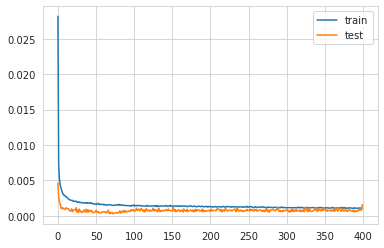

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [16]:
# train autoencoder for regression with no compression in the bottleneck layer
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import ReLU
from keras.layers import BatchNormalization
from keras.utils import plot_model
from matplotlib import pyplot
# define dataset
#X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# number of input columns
n_inputs = X_train.shape[1]
# split into train test sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
# scale data
t = MinMaxScaler()
t.fit(X_train)
X_train = t.transform(X_train)
X_test = t.transform(X_test)
# define encoder
visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = ReLU()(e)
# define bottleneck
n_bottleneck = n_inputs
bottleneck = Dense(n_bottleneck)(e)
# define decoder
d = Dense(n_inputs*2)(bottleneck)
d = BatchNormalization()(d)
d = ReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)
# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')
# plot the autoencoder
plot_model(model, 'autoencoder.png', show_shapes=True)
# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=400, batch_size=16, verbose=2, validation_data=(X_test,X_test))
# plot loss
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)
plot_model(encoder, 'encoder.png', show_shapes=True)
# save the encoder to file
encoder.save('encoder.h5')

In [17]:

y_train = y_train.ravel()
y_test = y_test.ravel()

# support vector regression performance with encoded input
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from keras.models import load_model
# define dataset
#???X, y = make_regression(n_samples=1000, n_features=100, n_informative=10, noise=0.1, random_state=1)
# split into train test sets
#???X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)
print("Before:")
print(y_train[0:5])
print(y_test[0:5])
# reshape target variables so that we can transform them
y_train = y_train.reshape((len(y_train), 1))
y_test = y_test.reshape((len(y_test), 1))
# scale input data
trans_in = MinMaxScaler()
trans_in.fit(X_train)
X_train = trans_in.transform(X_train)
X_test = trans_in.transform(X_test)
# scale output data
trans_out = MinMaxScaler()
trans_out.fit(y_train)
y_train = trans_out.transform(y_train)
y_test = trans_out.transform(y_test)
print("Scaled:")
print(y_train[0:5])
print(y_test[0:5])
# load the model from file
encoder = load_model('encoder.h5')
# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)
# define model
model = SVR()
# fit model on the training dataset
model.fit(X_train_encode, y_train)
# make prediction on test set
yhat = model.predict(X_test_encode)
# invert transforms so we can calculate errors
yhat = yhat.reshape((len(yhat), 1))
yhat = trans_out.inverse_transform(yhat)
y_test = trans_out.inverse_transform(y_test)
# calculate error
score = mean_absolute_error(y_test, yhat)
print(score)

Before:
[525000. 225000. 475000. 475000. 425000.]
[400000. 369950. 350000. 549000. 495000.]
Scaled:
[[0.85]
 [0.25]
 [0.75]
 [0.75]
 [0.65]]
[[0.6   ]
 [0.5399]
 [0.5   ]
 [0.898 ]
 [0.79  ]]
138/138 [==============================] - 0s 953us/step


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


55959.007878356526


In [18]:
print(y_test)

[[400000.]
 [369950.]
 [350000.]
 ...
 [400000.]
 [450000.]
 [275000.]]


In [19]:
from sklearn.svm import SVR
from keras.saving.save import load_model

# load the model from file
encoder = load_model('encoder.h5')

# encode the train data
X_train_encode = encoder.predict(X_train)
# encode the test data
X_test_encode = encoder.predict(X_test)

# define model
model = SVR()
# fit model on the training dataset
model.fit(X_train_encode, y_train)
# make prediction on test set
yhat = model.predict(X_test_encode)

yhat = model.predict(X_test_encode)
# invert transforms so we can calculate errors
yhat = yhat.reshape((len(yhat), 1))
yhat = trans_out.inverse_transform(yhat)
y_test = trans_out.inverse_transform(y_test)
# calculate error
score = mean_absolute_error(y_test, yhat)
print(score)

138/138 [==============================] - 0s 1ms/step


/usr/local/lib/python3.9/dist-packages/sklearn/utils/validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


212534162863.56067


In [44]:
print(y_test[0], yhat[0])

[400000.] [405828.26935591]


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage:
* #### retrieve the hyperparameters for this model, and
* #### train the model



In [20]:
trainable_model, ALGORITHM_DETAIL, chosen_epochs, chosen_params = make_simple_ann(selected_neural_network)

ALGORITHM_DETAIL

'mae +epochs=400 +learn=0.0003'

In [21]:
print("selected_neural_network",selected_neural_network)
trainable_model.summary()

selected_neural_network m15 mega + dropout
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 21)               43        
 n)                                                              
                                                                 
 dense_8 (Dense)             (None, 128)               2816      
                                                                 
 dense_9 (Dense)             (None, 256)               33024     
                                                                 
 batch_normalization_5 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 activation (Activation)     multiple                  0         
                                                                 
 dense_10 (De

In [22]:
val_split = 0.1
min_delta=0 #10, #50, #10, #50,
val_delta_patience = 25 # 10

# https://keras.io/api/callbacks/early_stopping/
callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", #"loss", #"val_loss",
    min_delta=min_delta, 
    patience=val_delta_patience,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True # False,
)

pipe_start = time()

history = trainable_model.fit(
    X_train,
    y_train,
    epochs=chosen_epochs,
    # verbose=0 to suppress logging.
    verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split=val_split,  #0.2,
    callbacks=[callback],
)
pipe_end = time()
estimated_time = round((pipe_end - pipe_start), 2)

Epoch 1/400
1117/1117 [==============================] - 10s 7ms/step - loss: 0.1628 - val_loss: 0.1212
Epoch 2/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1283 - val_loss: 0.1262
Epoch 3/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1230 - val_loss: 0.1168
Epoch 4/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1206 - val_loss: 0.1142
Epoch 5/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1178 - val_loss: 0.1182
Epoch 6/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1165 - val_loss: 0.1103
Epoch 7/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1150 - val_loss: 0.1155
Epoch 8/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1141 - val_loss: 0.1073
Epoch 9/400
1117/1117 [==============================] - 8s 7ms/step - loss: 0.1138 - val_loss: 0.1083
Epoch 10/400
1117/1117 [==============================] - 8s 7ms/step - 

In [23]:
#ALGORITHM_DETAIL.replace("epochs=", f"epochs={len(hist)}/")

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Get the results and print some graphs



In [24]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

early_end_lossX = hist.iloc[-1]['loss']
early_end_loss = hist['loss'].min()
early_end_valloss = hist['val_loss'].min()

#more_detail = f"loss={round(early_end_loss,2)} valloss={round(early_end_valloss,2)}"
more_detail = f"loss={early_end_loss:.2e} valloss={early_end_valloss:.2e}"
more_detail += f' +valsplit={val_split} +patn={val_delta_patience}'

# f"{x:.2e}"

if len(hist) != chosen_epochs:
    print(f'stopped at {len(hist)}, loss={round(early_end_loss,2)} valloss={round(early_end_valloss,2)}')
    #ALGORITHM_DETAIL += f" +stop={len(hist)}"
    more_detail += f" stop={len(hist)}/{chosen_epochs} "
    #more_detail += ALGORITHM_DETAIL.replace("epochs=", f"epochs={len(hist)}/")


if price_divisor!=1:
    print('in preprocessing, divided all Prices by ', price_divisor)
    more_detail += f' div={price_divisor}'


print(more_detail)
print(ALGORITHM_DETAIL)
    
hist.tail()

stopped at 126, loss=0.09 valloss=0.1
loss=8.53e-02 valloss=9.72e-02 +valsplit=0.1 +patn=25 stop=126/400 
mae +epochs=400 +learn=0.0003


,loss,val_loss,epoch
121,0.085584,0.102539,121
122,0.085786,0.097605,122
123,0.085499,0.098600,123
124,0.085337,0.100067,124
125,0.085297,0.098536,125


100.04094029963017
10.004094029963017


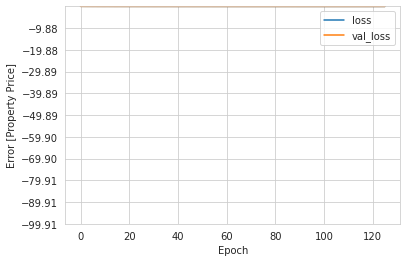

In [25]:
def plot_loss(history):
    loss_fig, loss_ax = plt.subplots()
    loss_ax.plot(history.history['loss'], label='loss')
    loss_ax.plot(history.history['val_loss'], label='val_loss')
    #plt.ylim([0, 10])
    min_y = min(min(history.history['val_loss']),min(history.history['loss'])) - 100
    #max_y = min(max(history.history['val_loss']),max(history.history['loss'])) + 500
    #max_y = min(sorted(history.history['val_loss'])[-3],sorted(history.history['loss'])[-3]) + 100
    max_y = min(sorted(history.history['val_loss'])[-1],sorted(history.history['val_loss'])[-1])
    
    print(max_y - min_y)
    ticks = (max_y - min_y)/10
    print(ticks)
    
    plt.ylim([min_y, max_y])
    plt.xlabel('Epoch')
    plt.ylabel('Error [Property Price]')
    plt.legend()
    plt.grid(True)
    plt.yticks(np.arange(min_y, max_y, ticks))  # JHJH
    return loss_fig, loss_ax

loss_fig, loss_ax = plot_loss(history)

In [26]:
y_pred = trainable_model.predict(X_test)

138/138 [==============================] - 0s 2ms/step


In [27]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Neural Network m15 mega + dropout----------
R square Accuracy -15.994804906238336
Mean Absolute Error Accuracy 212534587876.0771
Mean Squared Error Accuracy 4.7995052450841444e+22
Root Mean Squared Error 219077731526.60095


In [28]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [29]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)

combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
85476739,217500100000,0,2.175001e+11,100.0,7.069250e+13,435000,1,1,0.865284,51.501799,0.053130,0.002079,0.157550,LEASEHOLD
85540923,275000100000,0,2.750001e+11,100.0,6.325818e+13,550000,2,1,0.728866,51.474917,0.026607,0.024803,0.131027,LEASEHOLD
117403586,152500100000,0,1.525001e+11,100.0,6.031862e+13,305000,1,1,0.340743,51.382480,-0.156277,0.117240,0.051857,LEASEHOLD
103999217,241875100000,0,2.418751e+11,100.0,6.029209e+13,483750,2,1,0.655006,51.508423,0.073162,0.008703,0.177582,LEASEHOLD
118948271,290000100000,0,2.900001e+11,100.0,5.972515e+13,580000,1,1,0.231182,51.506587,0.075455,0.006867,0.179875,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123509066,116000100000,0,1.160001e+11,100.0,1.388397e+13,232000,1,1,0.153684,51.512190,-0.134790,0.012470,0.030370,LEASEHOLD
83639617,95000100000,0,9.500010e+10,100.0,1.249071e+13,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
109722224,54000100000,0,5.400010e+10,100.0,1.225851e+13,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
85667184,61000100000,0,6.100010e+10,100.0,1.182165e+13,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD


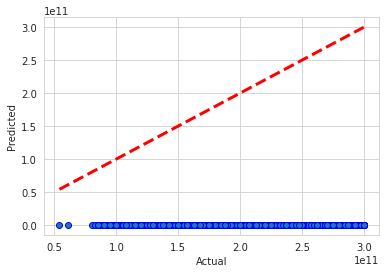

In [30]:
best_model_fig, best_model_ax = plt.subplots()
best_model_ax.scatter(y_test, y_pred, edgecolors=(0, 0, 1))
best_model_ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
best_model_ax.set_ylabel('Predicted')
best_model_ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')

plt.show()

<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Evaluate the model



In [31]:
cv_best_model_fit_time = estimated_time

DD2 = "(" + ",".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} (v{VERSION})'.lower()

method = f"{ALGORITHM_DETAIL}{DD2}"

new_results = {
    #'_score': score,
    '_score': R2,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE * price_divisor,
    'Mean Squared Error Accuracy': MSE * price_divisor,
    'Root Mean Squared Error': RMSE * price_divisor,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    #'_params': crossval_runner.best_params_ if not_catboost else cat_params,
    #'_params': 'not available', # REPLACED - can't have different models all saying params not available
    '_params': ALGORITHM_DETAIL,
    '_method': more_detail, #ALGORITHM_DETAIL,
    'run_env': run_env
}

if run_env not in ['colab']:
    old_results_json = get_results()
    try:
        old_best_score = old_results_json[key]['best score']
    except:
        print(f"haven't scored this model yet: {ALGORITHM}")
        old_best_score = -999
    this_model_is_best = update_results(old_results_json, new_results, key)

print(key)
print(ALGORITHM_DETAIL)

neural network m15 mega + dropout (v09)
mae +epochs=400 +learn=0.0003


In [32]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        pickle.dump(trainable_model, f)
        new_model_decision = f"pickled new version of model\n{old_results_json[key]['_score']} is new best score (it's better than {old_best_score})"
        #print(results_json[key]['_score'], 'is an improvement on', results_json[key]['second best score'])
else:
    new_model_decision = f"not updated saved model, the previous run was better\n{old_results_json[key]['_score']} is worse than or equal to {old_best_score}"

print(new_model_decision)

not updated saved model, the previous run was better
-15.994804906238336 is worse than or equal to 0.6222346763480049


<code style="background:blue;color:blue">**********************************************************************************************************</code>

## Stage: Write the final report for this algorithm and dataset version

In [33]:
from bs4 import BeautifulSoup


def include_in_html_report(type, section_header=None, section_figure=None, section_content=None, section_content_list=None):

    # writePath_html = r'model_results/%s (html).html' % key
    # writePath_md = r'model_results/%s (md).md' % key
    results_root = '../../F_evaluate_model'
    writePath_html = f'{results_root}/html/{key}.html'.replace(" ", "_").replace("(", "_").replace(")", "_")
    writePath_md = f'{results_root}/markdown/{key}.md'

#isinstance(ini_list2, list)
    if not section_content_list:
        section_content_list = [section_content]

    if type == 'header':
        w = 'w' if section_figure <= 1 else 'a'
        with open(writePath_html, w) as f1:
            headers = f'<h{section_figure}>{section_content}</h{section_figure}>'
            f1.write(headers)
        with open(writePath_md, w) as f2:
            headers = f'{"#" * int(section_figure)} {section_content }\n'
            f2.write(headers)
    else:
        if section_header:
            with open(writePath_html, 'a') as f1:
                f1.write(f'<h3>{section_header}</h3>')
            with open(writePath_md, 'a') as f2:
                f2.write(f'### {section_header}\n')

        if type=='dataframe':
            with open(writePath_html, 'a') as f1:
                dfAsString = section_content.to_html()
                f1.write(dfAsString)
            with open(writePath_md, 'a') as f2:
                dfAsString = section_content.to_markdown()
                f2.write(dfAsString + '\n\n')
        elif type=='graph':
            filename = key + "_" + section_content
            #section_figure.savefig(f'model_results/artifacts/{filename.replace(" ", "_")}')
            section_figure.savefig(f'{results_root}/artifacts/{filename.replace(" ", "_").replace("(", "_").replace(")", "_")}')

            with open(writePath_html, 'a') as f1:
                dfAsString = f'<img src="../artifacts/{filename.replace(" ","_").replace("(", "_").replace(")", "_")}"/>'
                f1.write(dfAsString)

            with open(writePath_md, 'a') as f2:
                #dfAsString = f'(./model_results/artifacts/{filename}) \n'
                #dfAsString = f'![detail](./artifacts/{filename.replace(" ","_")})'
                dfAsString = f'![detail](../artifacts/{filename.replace(" ","_").replace("(", "_").replace(")", "_")})'
                f2.write(dfAsString)
                f2.write('\n\n')
        elif type=='json':

            # html_content_parsed = [[cell.text for cell in row("td")]
            #              for row in BeautifulSoup(content,features="html.parser")("tr")]
            #
            # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}

            #xxxprint(json.dumps(html_content_dictionary, indent=4))



            with open(writePath_html, 'a') as f1:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                f1.write(str(soup.prettify()))
            with open(writePath_md, 'a') as f2:
                #f.write(json.dumps(html_content_dictionary, indent=4))
                soup = BeautifulSoup(section_content, "html.parser")
                #f2.write(str(soup.prettify()))


                # html_content_dictionary = {element[0]:element[1:] for element in html_content_parsed}
                # f2.write(json.dumps(html_content_dictionary, indent=4))

                import ast
                loads = ast.literal_eval(section_content)
                #df = pd.DataFrame.from_dict(loads)
                #df.drop(['dont'], axis=1, inplace=True)
                #print(df.to_markdown(index=False,tablefmt='fancy_grid'))
                for each in loads:
                    f2.write(each + " = " + str(loads[each]) + "\n\n")

        elif type=='dict':

            for section_content in section_content_list:
                if isinstance(section_content, str):
                    import ast
                    section_content = ast.literal_eval(section_content)

                with open(writePath_html, 'a') as f1:
                    soup = BeautifulSoup(str(section_content), "html.parser")
                    f1.write(str(soup.prettify()))
                with open(writePath_md, 'a') as f2:
                    for each in section_content:
                        f2.write(each + " = " + str(section_content[each]) + "\n\n")

        elif type=='text':
            with open(writePath_html, 'a') as f1:
                for each_line in section_content_list:
                    f1.write(each_line + '<br>')
            with open(writePath_md, 'a') as f2:
                for each_line in section_content_list:
                    f2.write(each_line + '\n\n')

        with open(writePath_html, 'a') as f1:
            f1.write('<hr>')


include_in_html_report("header", section_content=f"Results from {ALGORITHM}", section_figure=1)

end_timestamp = datetime.now()

include_in_html_report(type="text", section_header=f"Dataset Version: {VERSION}", section_content_list=[
    f"Date run: {datetime.now()}"
    "",
    f"Start time: {start_timestamp}",
    f"End time: {end_timestamp}",
])

include_in_html_report("header", section_content=f"Results", section_figure=2)

include_in_html_report(type="text", section_header="Summary", section_content=new_model_decision)


include_in_html_report(type='graph', section_header="Best Model: Comparing model predictions to actual property values", section_figure=best_model_fig, section_content='best_ann_model.png')

#include_in_html_report(type="dataframe",text_single="Tuned Models ranked by performance", content=cv_results_df_sorted)

include_in_html_report(type="text", section_header="Model Specific Notes", section_content_list=["can't display hyperparameter comparison for neural network","can't display model performance graphs for neural network","can't display model performance graphs for neural network"])

include_in_html_report(type="dataframe", section_header="Neural Network Loss - Head", section_content=hist.head())

include_in_html_report(type="text", section_header=None, section_content='')

include_in_html_report(type="dataframe", section_header="Neural Network Loss - Tail", section_content=hist.tail())


include_in_html_report(type='graph', section_header=None, section_figure=loss_fig, section_content='end_loss.png')

import io
def get_model_summary(model):
    stream = io.StringIO()
    model.summary(line_length=160, print_fn=lambda x: stream.write('>' + x.replace('-','').replace('=','') + '\n'))
    summary_string = stream.getvalue()
    stream.close()
    return summary_string

short_model_summary = get_model_summary(trainable_model)

include_in_html_report(type="text", section_header="Model Structure", section_content=short_model_summary)

include_in_html_report("header", section_content=f"Comparison with other models", section_figure=2)


dff = pd.read_json('../../../results/results.json')

version = VERSION


all_models_df = dff[dff.columns].T.sort_values("best score", ascending=False)
version_models_df = dff[[c for c in dff.columns if version in c]].T.sort_values("best score", ascending=False)

version_models_summary = version_models_df[['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy', 'Root Mean Squared Error', 'best run date', 'best method']]
all_models_summary = all_models_df[['best score', 'best time', 'Mean Absolute Error Accuracy', 'Mean Squared Error Accuracy', 'R square Accuracy', 'Root Mean Squared Error', 'best run date', 'best method']]

include_in_html_report(type="dataframe", section_header=f"Comparison with version {VERSION} performances", section_content=version_models_summary)
include_in_html_report(type="dataframe", section_header="Comparison with all model performances", section_content=all_models_summary)


include_in_html_report("header", section_content=f"Appendix", section_figure=2)

include_in_html_report(type="dataframe", section_header="Data Sample", section_content=df.head(5))

if False:
    include_in_html_report(type="json", section_header="Hyperparameter options for Randomized Grid Search", section_content=f"{param_options if not using_catboost else options_block}")
else:

    include_in_html_report(type="text", section_header="FIX THIS!!", section_content="FIX THIS!")

include_in_html_report(type="dict", section_header="Environment Variables", section_content=env_vars)

include_in_html_report(type="text", section_header="Useful info",
                       section_content_list=[f"Tensorflow version: {tf.__version__}"
                                        ])


def print_and_report(text_single, title):
    include_in_html_report("text", section_content=title)
    for each in text_single:
        print(each)
        include_in_html_report("text", section_header="", section_content=each)

# if not catboost:
#     print_and_report([
#         'Best Index:' + str(crossval_runner.best_index_) + '<br>',
#         'Best Score:' + str(crossval_runner.best_score_) + '<br>',
#         'Best Params: ' + str(crossval_runner.best_params_) + '<br>'
#     ], "Best Model Details")



In [34]:
print('Nearly finished...')

Nearly finished...


In [35]:
if create_python_script and is_jupyter:
    !jupyter nbconvert --to script 'neural_networks_with_autoencoder_20221214.ipynb'

[NbConvertApp] Converting notebook neural_networks_with_autoencoder_20221214.ipynb to script
[NbConvertApp] Writing 41460 bytes to neural_networks_with_autoencoder_20221214.py


In [36]:
print('Finished!')

Finished!
